# Backtest Framework

Archer

## 1. Components

|Component|Intro|
|:-:|:-|
|Data|Data retriver class, for aligning data types and useful functions such as getting rolling based data for avoiding look ahead bias.|
|Trade|Trade class, which includes exit, stoploss, take profit strategy; trade current position; trade status; etc.|
|Backtest|Backtest class, which includes: 1. backtest on rolling basis, support close out positions based on trades specific exit rules; 2. wallet for saving spot status, i.e. buy/sell asset, get current holding; 3. Summary function, support strategy NAV and holding NAV plot, as well as strategy analysis.|

## 2. Data

```Python
class Data:
    def __init__(self, universe, price_to_use='Adj Close'):
        # get data
        self.data_raw = GetData(names=universe)
        # price to use
        self.price_to_use = price_to_use
    
    def get_rolling_one(self, date, asset, rolling_window, shift_back=1):
        '''get rolling info for one asset
        shift_back is for backwarding dates:
            shift_back == 0: including data on date
            shift_back == 1: does not include data on date
        return Series
        '''
        # tradable on the day
        check = self.get_asset_price_daily(asset, date)
        if check is not None:
            dates = self.data_raw[asset].Date.to_list()
            idx = dates.index(date)
            if idx-rolling_window < 0:
                return None
            dates_to_use = dates[max(0, idx-rolling_window):max(1,idx+1-shift_back)]
            return self.data_raw[asset][['Date',self.price_to_use]].set_index('Date')[dates_to_use[0]:dates_to_use[-1]][self.price_to_use]
        else:
            return None
    
    def get_rolling(self, date, universe, rolling_window, shift_back=1):
        '''get rolling info for all assets in universe
        '''
        rolling_rst = {}
        for asset in universe:
            temp = self.get_rolling_one(date, asset, rolling_window, shift_back=shift_back)
            if temp is not None:
                rolling_rst[asset] = temp
        return rolling_rst
    
    def get_asset_price_daily(self, asset, date):
        '''get asset price for the day, if not exist, return None
        '''
        data = self.data_raw[asset]
        if date in data.Date.to_list():
            return data[['Date',self.price_to_use]].set_index('Date')[self.price_to_use][date]
        else:
            return None
    
    def get_all_trading_days(self):
        '''get all trading days from self.data_raw
        defination: if any asset in universe has value, then it's a trading day.
            if can obtain any index from yfinance, then should use index date as trading day
        '''
        date_set = set()
        for asset in self.data_raw:
            date_set = date_set|set(self.data_raw[asset].Date.to_list())
        date_list = list(date_set)
        date_list.sort()
        return date_list
    
```

Generate a sample universe for retriving data

In [1]:
import pandas as pd

from get_data import Get_SP500
# sample sector
spinfo = Get_SP500(output='all').set_index('Symbol').to_dict()
temp = pd.Series(spinfo['GICS Sector']).reset_index()
temp.columns=['id','indust']
universe = temp[temp['indust'] == 'Information Technology'].id.to_list()[:10]
universe

['ACN', 'ADBE', 'AMD', 'AKAM', 'APH', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET']

Generate a Data object to retrive data and find below functions:

|Function|Discription|
|-|-|
|.get_all_trading_days()|Get all trading days from given data|
|.get_rolling(date, universe, rolling_window)|Get data from trading universe without lookahead bias by fetching previous n day data|
|.get_asset_price_daily(asset, date)|A short cut for getting asset price|

In [6]:
from backtest_data import Data
a = Data(universe)
# get trading day
a.get_all_trading_days()[:5]

['2009-12-31', '2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07']

In [10]:
# samples
rolling_window = 5
date = '2013-10-07'
asset = 'ACN'
# get history data for all assets, in format of dictionary
print(a.get_rolling(date, universe, rolling_window))
# get history data for one asset
print(a.get_rolling_one(date, asset, rolling_window, shift_back=0))
# get asset price for one day
print(a.get_asset_price_daily(asset, date))

{'ACN': Date
2013-09-30    63.173965
2013-10-01    63.328377
2013-10-02    63.062447
2013-10-03    62.745033
2013-10-04    62.847977
Name: Adj Close, dtype: float64, 'ADBE': Date
2013-09-30    51.939999
2013-10-01    52.430000
2013-10-02    51.520000
2013-10-03    50.880001
2013-10-04    51.570000
Name: Adj Close, dtype: float64, 'AMD': Date
2013-09-30    3.81
2013-10-01    3.86
2013-10-02    3.90
2013-10-03    3.90
2013-10-04    3.91
Name: Adj Close, dtype: float64, 'AKAM': Date
2013-09-30    51.700001
2013-10-01    52.419998
2013-10-02    52.220001
2013-10-03    51.160000
2013-10-04    52.320000
Name: Adj Close, dtype: float64, 'APH': Date
2013-09-30    36.271671
2013-10-01    36.384167
2013-10-02    36.351364
2013-10-03    35.741993
2013-10-04    35.854481
Name: Adj Close, dtype: float64, 'ADI': Date
2013-09-30    39.963699
2013-10-01    40.014664
2013-10-02    39.751358
2013-10-03    39.343636
2013-10-04    39.912735
Name: Adj Close, dtype: float64, 'ANSS': Date
2013-09-30    86.51

## 3. Trade

Think of a simple strategy:

* Entry: short ADBE and long ACN for 1 unit as Z score of their price ratio swing 2 std away form mean;
* Exit: ratio revert back to within 1 std from mean;

Note: here, the mean and std are all on rolling basis, indicating we expect the market is anchoring on the moving average than the fixed mean level when we build the strategy.(Actually it's easier in coding if we use the fixed level for exit)

### Sample
```python
a_trade = Trade( position_dict = {a1:-1, a2: 1}, 
                                    name = 'pairs:+ACN-AMD', 
                                    date = day1, 
                                    # pair_exit is a funciton
                                    strategy_exit = pair_exit)
```

### Close out strategies

* Incl. exit/stop loss/take profit
* each strategy is a function
* input of the function is `date`, `data`
* output is `True` or `False`

```Python
class Trade:
    def __init__(self, position_dict, name, date,
                 strategy_exit=lambda date, data:None, 
                 strategy_takeprofit=lambda date, data:None, 
                 strategy_stoploss=lambda date, data:None):
        '''
        Args:
            position_dict: units of each asset, dict
            name: name of strategy, in purpose of no duplicate
            date: current date, the date of the trade
            strategy_exit: func
            strategy_takeprofit: func
            strategy_stoploss: func
        '''
        self.position = position_dict
        self.name = name # strategy name
        self.current_status = 'In Use'
        self.status_hist = {date: 'In Use'}
        # strategies
        self.exit_strategy = strategy_exit
        self.take_profit_strategy = strategy_takeprofit
        self.stop_loss_strategy = strategy_stoploss
        
    def status_update(self, date, data):
        exits = self.exit_strategy(date, data)
        if exits:
            self.current_status = 'Exit'
            self.status_hist[date] = self.current_status
        
        takeprofits = self.take_profit_strategy(date, data)
        if takeprofits:
            self.current_status = 'Take Profit'
            self.status_hist[date] = self.current_status
        
        stoploss = self.stop_loss_strategy(date, data)
        if stoploss:
            self.current_status = 'Stop Loss'
            self.status_hist[date] = self.current_status
```

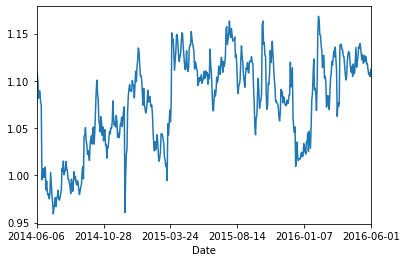

In [11]:
from trade_class import Trade
# regenerate universe
a1 = 'ACN'
a2 = 'ADBE'
universe = [a1, a2]
data = Data(universe)
# temp yr 2014-2016 stable relationship
data0 = data.get_rolling('2016-06-01', universe, 500, shift_back=0)
ratio = data0[a1]/data0[a2]
ratio.plot()

In [14]:
# data for check
rolling_window = 100

def sample_exit(date, data, threshold):
    long = data[a1]
    short = data[a2]
    ratio = short/long
    std = ratio.std()
    avg = ratio.mean()
    Z = (ratio[-1] - avg)/std
    return abs(Z) <= threshold

# generate trade on day1
pair_exit = lambda date, data: sample_exit(date, data, 0.5)
day1 = '2015-01-12'
pair = Trade(
        position_dict = {a1:-1, a2: 1}, 
        name = 'pairs:+ACN-AMD', 
        date = day1, 
        strategy_exit = pair_exit)
print(day1, pair.current_status)

2015-01-12 In Use


In [15]:
# update trade on day2
day2 = '2015-03-24'
data2 = data.get_rolling(day2, universe, rolling_window, shift_back=0)
pair.status_update(day2, data2)
print(day2, pair.current_status)
print(pair.status_hist)

2015-03-24 Exit
{'2015-01-12': 'In Use', '2015-03-24': 'Exit'}


## 4. Backtest



In [17]:
from backtest_class import Backtest
# exit strategy
def sample_exit(date, data, threshold=1.1):
    long = data[a1]
    short = data[a2]
    ratio = short/long
    std = ratio.std()
    avg = ratio.mean()
    Z = (ratio[-1] - avg)/std
    return abs(Z) <= threshold

# position entry rule, if enter, return a list of trades
def sample_enter_trade(date, data, threshold=2, exit_strategy = sample_exit):
    long = data[a1]
    short = data[a2]
    ratio = short/long
    std = ratio.std()
    avg = ratio.mean()
    Z = (ratio[-1] - avg)/std
    if abs(Z) >= threshold:
        # note: should return a Trade object here
        pair = Trade(
                position_dict = {a1:-1, a2: 1}, 
                name = 'pairs:+{}-{}'.format(a1, a2), 
                date = date, 
                strategy_exit = exit_strategy
                )
        return [pair]
    else:
        return []

# Generate Backtest using above entry rules
pairs = Backtest(sample_enter_trade, data, universe, look_back_period=80)

In [18]:
# daily check if any new positions can be entered
freq = 'D'
st = '2015-01-12'
ed = '2015-04-28'
pairs.timely_trade(freq=freq, st=st, ed=ed)
print(pairs.strategy_pool)
for i in pairs.strategy_pool:
    print(i.status_hist)

0/72 running...
Asset:ACN not in current wallet.
Asset:ADBE not in current wallet.
7/72 running...
14/72 running...
21/72 running...
28/72 running...
35/72 running...
42/72 running...
49/72 running...
56/72 running...
63/72 running...
70/72 running...
[<trade_class.Trade object at 0x000001724CCAD208>, <trade_class.Trade object at 0x000001724FCA3088>, <trade_class.Trade object at 0x0000017251775888>]
{'2015-01-13': 'In Use', '2015-01-23': 'Exit'}
{'2015-03-18': 'In Use', '2015-03-19': 'Exit'}
{'2015-03-27': 'In Use', '2015-04-23': 'Exit'}


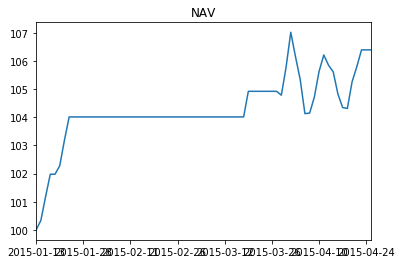

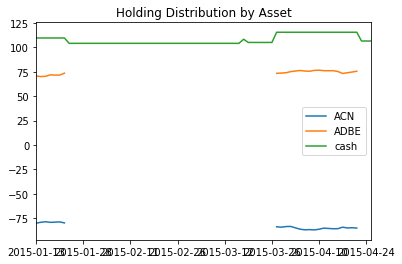

In [19]:
# plot the NAV of this trading strategy
pd.Series(pairs.NAV_all).plot(title='NAV')
# show the NAV of each individual asset
pd.DataFrame(pairs.NAV_indi).T.plot(title='Holding Distribution by Asset')

Source Code of Backtest:
```Python
class Wallet:
    '''For saving holding positions, count in units
    '''
    def __init__(self, initial_cash = 100):
        self.holding={'cash':initial_cash}
        
    def buy(self, asset, quantity, price):
        if asset not in self.holding:
            self.holding[asset] = 0
        self.holding[asset] += quantity
        self.holding['cash'] -= price*quantity
        
    def sell(self, asset, quantity, price):
        if asset not in self.holding:
            # it's possible to open a non-covered short position
            self.holding[asset] = 0
        self.holding[asset] -= quantity
        self.holding['cash'] += price*quantity

    def current_holding(self):
        '''return current holding and values'''
        current_holding = {}
        for i in self.holding:
            if self.holding[i] != 0:
                current_holding[i] = self.holding[i]
        return current_holding
    
    def get_position(self, asset):
        if asset not in self.holding:
            print('Asset:{} not in current wallet.'.format(asset))
            return 0
        else:
            return self.holding[asset]

class Backtest:
    def __init__(self, start_new_trades, data, universe, look_back_period=80):
        '''
        args:
            start_new_trades: a function for getting trades, must return a list of trades
            data: Data object
            universe: a list of tick names
            look_back_period: backtest period
        '''
        self.setup_backtest()
        self.setup_manual(start_new_trades, data, universe, look_back_period)

    def setup_backtest(self):
        # spot info
        self.wallet = Wallet()
        self.current_date = None
        self.strategy_pool = []
        # hist info
        self.num_trades = 0
        self.trading_hist = []
        self.holding_hist = []
        # statistical info
        self.NAV_all = {}
        self.NAV_indi = {}
    
    def setup_manual(self, start_new_trades, data, universe, look_back_period):
        self.lookback_period = look_back_period # rolling period
        self.start_new_trades = start_new_trades # get position, input=data, output = target position
        self.data = data # class, support get asset daily data
        self.universe = universe
        
    def timely_trade(self, freq, st=None, ed=None):
        '''timely initiate new trades
        '''
        all_dates = self.data.get_all_trading_days()
        if st is not None:
            all_dates = [x for x in all_dates if x > st]
        if ed is not None:
            all_dates = [x for x in all_dates if x < ed]
        # adjust frequency for all_dates
        trading_dates = reshuffle_dates(freq, all_dates)
        # execution
        for i, date in enumerate(all_dates):
            if i%(len(all_dates)//10)==0:
                print('{}/{} running...'.format(i, len(all_dates)))
            if date in trading_dates:
                self.actions(date)
            self.daily_summary()
            
    def daily_summary(self):
        '''generate summary statistics for current day
        '''
        today = self.current_date
        current_holding = self.wallet.current_holding()
        NAV = {
                x: current_holding[x] * self.data.get_asset_price_daily(x, today) 
                for x in current_holding if x != 'cash'
                }
        NAV['cash'] = current_holding['cash']
        self.NAV_indi[today] = NAV
        self.NAV_all[today] = sum(NAV.values())
        
    def actions(self, date):
        '''
        main function, responsible for daily issues
        flow:
            1. get relevant data
            2. get position
                old status check
                new add in
                sum position
            3. identify trades and validate trades
            4. trade execution
        '''
        self.current_date = date
        # 1. get data
        used_data = self.data.get_rolling(date, self.universe, self.lookback_period)
        
        '''
        mark: room to improve in c: count only the additional and sum them up
            
        # 2. get position
        a. for existing trades, update status
        b. add new trades to current pool
        c. calculate total units of position
        final output is units of position
        '''
        # a. update status
        active_strategies = [x for x in self.strategy_pool if x.current_status == 'In Use']
        for trade in active_strategies:
            trade.status_update(date, used_data)
        # b. open new trades
        # only open if currently not using same strategy
        new_trades = self.start_new_trades(date, used_data) # f(data), return dictionary, key=asset, value = units
        active_names = [x.name for x in active_strategies]
        for trade_i in new_trades:
            if trade_i.name not in active_names:
                self.strategy_pool.append(trade_i) 
        # c. sum target positions
        active_strategies = [x for x in self.strategy_pool if x.current_status == 'In Use']
        total_positions = [trade.position for trade in active_strategies]
        target_position = {} 
        for trade_pos in total_positions:
            for asset in trade_pos:
                if asset not in target_position:
                    target_position[asset] = trade_pos[asset] 
                else:
                    target_position[asset] += trade_pos[asset] 
#        print(date, target_position)
        
        # 3. identify trades, validate trades
        daily_trades = self.identify_trades(target_position) 
#        print(daily_trades)
        if len(daily_trades) > 0:
            self.trading_hist.append(daily_trades) 
            
        # 4. trade execution
        self.trades_execution(daily_trades, date) 
        
        #5. saving
        if len(daily_trades) > 0:
            holding_log = self.wallet.current_holding() 
            holding_log['date'] = date 
            self.holding_hist.append(holding_log) 

    def identify_trades(self, target_position):
        '''identify trades from targetposition and current position
        input:
            target position
        reff:
            current position
        return:
            trades to make in day
        '''
        daily_trades = []
        for i in self.wallet.current_holding():
            if i not in target_position and i != 'cash':
                target_position[i] = 0
        for i in target_position:
            current_pos = self.wallet.get_position(i)
            target_pos = target_position[i]
            # check tradable
            if not self.tradable(i, self.current_date):
                continue
            # trading info generation
            price = self.data.get_asset_price_daily(i, self.current_date)
            trade = {
                     'asset': i,
                     'date': self.current_date,
                     'price' : price
                     }
            if current_pos > target_pos:
                trade['direction'] = 'close'
                trade['quantity'] = current_pos - target_pos
                daily_trades.append(trade)
            elif current_pos < target_pos:
                trade['direction'] = 'open'
                trade['quantity'] = target_pos - current_pos
                daily_trades.append(trade)
        return daily_trades
    
    def tradable(self, asset, date):
        '''check if price exist for the day
        '''
        if self.data.get_asset_price_daily(asset, date) is not None: # asset has price info on the day
            return True
        else:
            return False

    def trades_execution(self, trades, date):
        '''execution
        trade = {'direction':'open',
                 'asset': 'cash',
                 'quantity': 100}
        trades = [trade1, trade2, ...]
        '''
        for trade in trades:
            self.open_trade(trade)
    
    def open_trade(self, trade):
        '''trading entry execution
        '''
        if trade['direction'] == 'open':
            self.wallet.buy(trade['asset'], trade['quantity'], trade['price'])
            self.num_trades += 1
            return
        elif trade['direction'] == 'close':
            self.wallet.sell(trade['asset'], trade['quantity'], trade['price'])
            self.num_trades += 1
            return
```